In [1]:
# Imports 
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import operator

In [2]:
# load the data, keep only selected columns
# Read the file using super fast Pandas.read_csv
def load_required_data(path, required_columns):
    dataframe = pd.read_json(path, lines=True)
    dataframe = dataframe[required_columns]
    return dataframe, dataframe.values

In [3]:
dataframe, values = load_required_data('train_15000.json', ["asin", "reviewerID", "overall"])

In [4]:
dataframe[:10]

,asin,reviewerID,overall
0,B00ANT8OF6,A00100742Q4O8VH0YMUBZ,4
1,B00AMR1HZ8,A00100742Q4O8VH0YMUBZ,4
2,B004WGGQPQ,A00100742Q4O8VH0YMUBZ,5
3,B006C1ZSO4,A00100742Q4O8VH0YMUBZ,5
4,B008LY1B32,A00100742Q4O8VH0YMUBZ,4
5,B007KPT2N4,A00100742Q4O8VH0YMUBZ,1
6,B0080JJLBW,A00100742Q4O8VH0YMUBZ,5
7,B009P8EMCK,A00100742Q4O8VH0YMUBZ,5
8,B00I8Q77Y0,A001619027H9L9EG4UVRB,5
9,B00H0BGCJK,A001619027H9L9EG4UVRB,5


In [5]:
dataframe.shape

(15000, 3)

In [6]:
# Create user-item matrix given a matrix and mapping from original matrix columns to new matrix rows/columns
def create_user_item_matrix(data, rowMapping, columnMapping):
    # Create table of users to items by taking row and column pivots
    # Rows of user-item table are users
    rows, row_pos = np.unique(data[:, rowMapping], return_inverse=True)
    # Columns of user-item table are movies
    cols, col_pos = np.unique(data[:, columnMapping], return_inverse=True)

    pivot_table = np.zeros((len(rows), len(cols)), dtype=data.dtype)
    pivot_table[row_pos, col_pos] = data[:, 2]
    return pivot_table, rows, cols

In [7]:
ratings_matrix, rows, cols = create_user_item_matrix(values, rowMapping=1, columnMapping=0)
print (ratings_matrix.shape)

(3139, 1842)


In [8]:
pd.DataFrame(ratings_matrix[:10], index = rows[:10], columns= cols)

,B004ALVL6W,B004ANMWPY,B004DLNC4I,B004DLPXAO,B004DM1OAQ,B004DM1ZQY,B004DPBGCO,B004DPC5Y2,B004DPCSKI,B004DPIEF6,...,B00K7WGUKA,B00KFNXUY0,B00KGCNRAM,B00KI5Q8X0,B00KMX5V8G,B00KOEHQCW,B00KQHVWWC,B00KSOQ66K,B00KWVZ750,B00L3MNCNQ
A00100742Q4O8VH0YMUBZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A001619027H9L9EG4UVRB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A002359833QJM7OQHCXWY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0037670NPLI11RBWYFA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A003841815JTX0JFLR8B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0038872349TB5N0JHQQW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00455683H6M1GQZMPQPV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
A0047670XAAJD587LXS7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00501041JRAPWYLPQ4TE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00507662MEMHI1YMGQ15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def get_index_map(arr):
    index_map = {}
    for el in arr:
        index_map[el] = len(index_map)
    return index_map

In [10]:
# Get unique movies and users
unique_items = np.unique(values[:,0])
unique_users = np.unique(values[:,1])

In [11]:
unique_items.shape

(1842,)

In [12]:
unique_users.shape

(3139,)

In [13]:
# Create mapping from unique list to 
item_idx_map = get_index_map(unique_items)
user_idx_map = get_index_map(unique_users)

In [14]:
mean_users = np.true_divide(ratings_matrix.sum(1), (ratings_matrix!=0).sum(1))
mean_items = np.true_divide(ratings_matrix.sum(0),(ratings_matrix!=0).sum(0))
mean_overall = np.true_divide(ratings_matrix.sum(),(ratings_matrix!=0).sum())

In [15]:
def get_users_who_rated_item(item_id):
    return np.where(ratings_matrix[:,item_idx_map[item_id]] > 0)[0]

def get_users_who_rated_item_by_index(item_idx):
    return np.where(ratings_matrix[:,item_idx] > 0)

def predict(user_id, item_id):
    item_idx = item_idx_map[item_id]
    user_idx = user_idx_map[user_id]
    bias_user = - mean_overall + mean_users[user_idx]
    bias_item = - mean_overall + mean_items[item_idx]
    return mean_overall + bias_user + bias_item

In [16]:
test_dataframe, test_values = load_required_data('test_5000.json', ["asin", "reviewerID", "overall"])

In [17]:
test_dataframe['reviewerID'].unique().shape

(2507,)

In [18]:
# Returns DF containing predictions, MAE, RMSE
def get_predictions(dataframe):
    df = dataframe.copy()
    print ("Predicting ratings..")
    start_time = time.time()
    df['Prediction'] = df.apply(lambda row: predict_row(row) , axis=1)
    MAE = round(mean_absolute_error(df['overall'], df['Prediction']), 2)
    RMSE = round(np.sqrt(mean_squared_error(df['overall'], df['Prediction'])), 2)
    print "Done Predicting in",  round((time.time() - start_time), 2), "seconds"
    return df, MAE, RMSE

i = 0
def predict_row(row):
    global i
    i+= 1
    prediction = predict(row['reviewerID'], row['asin'])
    print ("#", i, "Actual = ", row['overall'], "Predictioned = ", prediction)
    return prediction

In [19]:
df, MAE, RMSE = get_predictions(test_dataframe)

Predicting ratings..
('#', 1, 'Actual = ', 5, 'Predictioned = ', 5.0668666666666669)
('#', 2, 'Actual = ', 2, 'Predictioned = ', 3.2890888888888892)
('#', 3, 'Actual = ', 5, 'Predictioned = ', 4.2751999999999999)
('#', 4, 'Actual = ', 5, 'Predictioned = ', 5.7196444444444445)
('#', 5, 'Actual = ', 5, 'Predictioned = ', 4.5918666666666672)
('#', 6, 'Actual = ', 3, 'Predictioned = ', 4.8977490196078435)
('#', 7, 'Actual = ', 5, 'Predictioned = ', 3.9418666666666669)
('#', 8, 'Actual = ', 4, 'Predictioned = ', 3.0734456140350881)
('#', 9, 'Actual = ', 5, 'Predictioned = ', 5.513295238095238)
('#', 10, 'Actual = ', 5, 'Predictioned = ', 5.6050245614035088)
('#', 11, 'Actual = ', 1, 'Predictioned = ', 2.641866666666667)
('#', 12, 'Actual = ', 4, 'Predictioned = ', 4.2751999999999999)
('#', 13, 'Actual = ', 5, 'Predictioned = ', 4.9085333333333336)
('#', 14, 'Actual = ', 5, 'Predictioned = ', 4.8418666666666663)
('#', 15, 'Actual = ', 4, 'Predictioned = ', 4.3122370370370371)
('#', 16, 'Actu

('#', 439, 'Actual = ', 5, 'Predictioned = ', 3.1918666666666669)
('#', 440, 'Actual = ', 3, 'Predictioned = ', 1.9418666666666669)
('#', 441, 'Actual = ', 4, 'Predictioned = ', 2.4201275362318841)
('#', 442, 'Actual = ', 3, 'Predictioned = ', 3.1918666666666669)
('#', 443, 'Actual = ', 4, 'Predictioned = ', 4.2827757575757577)
('#', 444, 'Actual = ', 5, 'Predictioned = ', 5.1501999999999999)
('#', 445, 'Actual = ', 1, 'Predictioned = ', 3.7418666666666667)
('#', 446, 'Actual = ', 5, 'Predictioned = ', 4.9894857142857143)
('#', 447, 'Actual = ', 1, 'Predictioned = ', 3.0751999999999997)
('#', 448, 'Actual = ', 5, 'Predictioned = ', 4.0579380952380948)
('#', 449, 'Actual = ', 4, 'Predictioned = ', 3.0371047619047618)
('#', 450, 'Actual = ', 5, 'Predictioned = ', 4.141866666666667)
('#', 451, 'Actual = ', 5, 'Predictioned = ', 4.9418666666666669)
('#', 452, 'Actual = ', 5, 'Predictioned = ', 5.386726479750779)
('#', 453, 'Actual = ', 4, 'Predictioned = ', 4.7789037037037039)
('#', 454, '

('#', 1701, 'Actual = ', 5, 'Predictioned = ', 4.0847238095238101)
('#', 1702, 'Actual = ', 5, 'Predictioned = ', 3.7418666666666667)
('#', 1703, 'Actual = ', 4, 'Predictioned = ', 3.9085333333333336)
('#', 1704, 'Actual = ', 5, 'Predictioned = ', 4.7609142857142857)
('#', 1705, 'Actual = ', 4, 'Predictioned = ', 4.711097435897436)
('#', 1706, 'Actual = ', 1, 'Predictioned = ', 3.0252000000000003)
('#', 1707, 'Actual = ', 5, 'Predictioned = ', 3.7752000000000003)
('#', 1708, 'Actual = ', 5, 'Predictioned = ', 2.5668666666666669)
('#', 1709, 'Actual = ', 5, 'Predictioned = ', 3.5159407407407408)
('#', 1710, 'Actual = ', 5, 'Predictioned = ', 3.8257952380952385)
('#', 1711, 'Actual = ', 2, 'Predictioned = ', 4.0543666666666667)
('#', 1712, 'Actual = ', 4, 'Predictioned = ', 1.6842909090909095)
('#', 1713, 'Actual = ', 2, 'Predictioned = ', 3.5652432900432904)
('#', 1714, 'Actual = ', 5, 'Predictioned = ', 4.8892350877192978)
('#', 1715, 'Actual = ', 5, 'Predictioned = ', 5.48032820512820

('#', 2915, 'Actual = ', 5, 'Predictioned = ', 4.141866666666667)
('#', 2916, 'Actual = ', 5, 'Predictioned = ', 4.641866666666667)
('#', 2917, 'Actual = ', 5, 'Predictioned = ', 5.4061523809523813)
('#', 2918, 'Actual = ', 4, 'Predictioned = ', 5.0251999999999999)
('#', 2919, 'Actual = ', 4, 'Predictioned = ', 5.141866666666667)
('#', 2920, 'Actual = ', 5, 'Predictioned = ', 5.5572512820512818)
('#', 2921, 'Actual = ', 2, 'Predictioned = ', 3.6085333333333338)
('#', 2922, 'Actual = ', 5, 'Predictioned = ', 4.2474222222222231)
('#', 2923, 'Actual = ', 5, 'Predictioned = ', 5.386726479750779)
('#', 2924, 'Actual = ', 5, 'Predictioned = ', 4.7418666666666667)
('#', 2925, 'Actual = ', 5, 'Predictioned = ', 3.8322776255707764)
('#', 2926, 'Actual = ', 4, 'Predictioned = ', 4.3418666666666672)
('#', 2927, 'Actual = ', 5, 'Predictioned = ', 4.1918666666666669)
('#', 2928, 'Actual = ', 4, 'Predictioned = ', 3.3125563218390806)
('#', 2929, 'Actual = ', 5, 'Predictioned = ', 5.4180571428571431)

('#', 4060, 'Actual = ', 5, 'Predictioned = ', 4.4789037037037041)
('#', 4061, 'Actual = ', 5, 'Predictioned = ', 5.2335333333333338)
('#', 4062, 'Actual = ', 5, 'Predictioned = ', 5.4835333333333338)
('#', 4063, 'Actual = ', 5, 'Predictioned = ', 3.5706545454545462)
('#', 4064, 'Actual = ', 3, 'Predictioned = ', 3.4752000000000005)
('#', 4065, 'Actual = ', 5, 'Predictioned = ', 4.8008410256410263)
('#', 4066, 'Actual = ', 5, 'Predictioned = ', 5.0535291976840364)
('#', 4067, 'Actual = ', 4, 'Predictioned = ', 4.641866666666667)
('#', 4068, 'Actual = ', 5, 'Predictioned = ', 4.4418666666666669)
('#', 4069, 'Actual = ', 5, 'Predictioned = ', 5.4992437158469949)
('#', 4070, 'Actual = ', 4, 'Predictioned = ', 4.8168666666666669)
('#', 4071, 'Actual = ', 4, 'Predictioned = ', 4.2196444444444445)
('#', 4072, 'Actual = ', 5, 'Predictioned = ', 4.3863111111111115)
('#', 4073, 'Actual = ', 2, 'Predictioned = ', 4.1157797101449276)
('#', 4074, 'Actual = ', 5, 'Predictioned = ', 5.15019999999999

In [20]:
print "MAE=", MAE
print "RMSE=", RMSE

MAE= 1.0
RMSE= 1.37


In [21]:
sparse_ratings = csr_matrix(ratings_matrix, dtype='float')

In [22]:
model_knn = NearestNeighbors(metric = 'cosine', n_neighbors = 6)
model_knn.fit(sparse_ratings)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=6, p=2, radius=1.0)

In [23]:
def get_recommendations(user_index, n_reccomendations=5, n_neighbors=10):
    distances,indices = model_knn.kneighbors(ratings_matrix[user_index].reshape(1, -1), n_neighbors=n_neighbors)
    probable_items = list()
    for user in indices[0]:
        if user == user_index:
            #print "Recommendations for user ", unique_users[user_index]
            continue
        # all other users
        for items in np.nonzero(ratings_matrix[user]):
            for item in items:
                if ratings_matrix[user_index][item] == 0:
                    probable_items.append(unique_items[item])

    predictions = {}
    for item in probable_items:
        predictions[item] = predict(unique_users[0], item)
        sorted_predictions = sorted(predictions.items(), key=operator.itemgetter(1))
    return [i[0] for i in sorted_predictions[:n_reccomendations]]

In [24]:
def get_user_items_rated_df(user_id):
    df = pd.DataFrame()
    np.nonzero(ratings_matrix[user_id])
    for i in np.nonzero(ratings_matrix[user_id]):
        x = pd.DataFrame({"item":unique_items[i], "rating":ratings_matrix[user_id][i]})
        df = df.append(x)
        return df

def print_items_rated(user_id):
    np.nonzero(ratings_matrix[user_id])
    for i in unique_items[np.nonzero(ratings_matrix[user_id])]:
        print i

In [25]:
get_user_items_rated_df(0)

,item,rating
0,B004WGGQPQ,5
1,B006C1ZSO4,5
2,B007KPT2N4,1
3,B0080JJLBW,5
4,B008LY1B32,4
5,B009P8EMCK,5
6,B00AMR1HZ8,4
7,B00ANT8OF6,4


[u'B004Z2VHAQ', u'B00I6IKSZ0', u'B007BTE2F2', u'B00G4FAU14', u'B00A13BI7U']


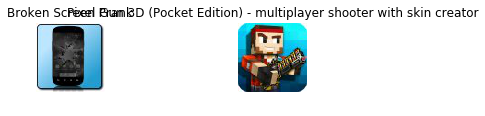

In [29]:
print get_recommendations(user_index=0)
import asin_to_rec
asin_to_rec.get_recommendation_items(get_recommendations(user_index=0)[:2])